In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random
import numpy as np
import datetime

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

C:\Users\Sonia\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [3]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders', 'laundry_distance']], on='customer_db_id', how='left')
df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord['order_created_month'] = df_ord.order_created_datetime.dt.month
df_ord['order_created_weekday'] = df_ord.order_created_datetime.dt.weekday
df_ord['order_created_year'] = df_ord.order_created_datetime.dt.year

df_ord.pickup_timeslot_from_datetime = pd.to_datetime(df_ord.pickup_timeslot_from_datetime)
df_ord.pickup_timeslot_to_datetime = pd.to_datetime(df_ord.pickup_timeslot_to_datetime)

df_ord['pickup_timeslot_from'] = df_ord.pickup_timeslot_from_datetime.dt.hour
df_ord['pickup_timeslot_to'] = df_ord.pickup_timeslot_to_datetime.dt.hour

In [4]:
df_items = pd.read_csv('../data/input/items.csv')
df_items = df_items.groupby('order_id').agg({'quantity': 'sum', 'product_type': 'nunique'}).reset_index()
df_items = df_items.rename(columns={'product_type': 'num_unique_products'})
df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [5]:
df_clusters = pd.read_csv('../data/input/item_clusters_cities.csv')
df_clusters['cluster'] = df_clusters.cluster.apply(lambda x: int(x[-1])).astype(int)
df_ord = df_ord.drop(['cluster'], axis=1).merge(df_clusters, on='order_id', how='left')

In [6]:
df_ord.loc[df_ord.corporate, 'service_class'] = 'CORP'
df_ord['service_class_paid'] = False
df_ord.loc[df_ord.service_class.isin(['EXPRESS', 'PLUS']), 'service_class_paid'] = True
# df_ord = df_ord.join(pd.get_dummies(df_ord['cluster_city'], prefix='cluster'))
# df_ord = df_ord.join(pd.get_dummies(df_ord['service_class'], prefix='service'))

In [7]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,laundry_distance,order_created_month,order_created_weekday,order_created_year,pickup_timeslot_from,pickup_timeslot_to,quantity,num_unique_products,cluster,service_class_paid
0,DE-A-00034,56b8af2ad2cde8d32d0f0671,57c688d6d4cde8a02a40955c,52.527650,13.411222,2016-08-31 19:00:00,2016-08-31 21:00:00,10178,completed,2016-08-31 09:35:50,...,NaN,8,2,2016,19,21,NaN,NaN,NaN,False
1,DE-A-00036,578724ecd3cde8ad719cc945,5ba4a69219207a41d47962df,52.539535,13.425363,2018-09-24 20:00:00,2018-09-24 21:00:00,10435,completed,2018-09-21 10:06:42,...,NaN,9,4,2018,20,21,1.0,1.0,1.0,True
2,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,1534.916467,8,1,2018,9,10,1.0,1.0,1.0,True
3,DE-A-00093,5a81b405447709dd6c8b4617,5a81b40a4677097f388b4576,52.488000,13.389250,2018-02-14 08:00:00,2018-02-14 09:00:00,10965,completed,2018-02-12 16:34:34,...,734.901875,2,0,2018,8,9,1.0,1.0,1.0,True
4,DE-A-00132,58d04f7246770953128b4740,5af0b68ec34362325828f24d,52.537420,13.399321,2018-05-09 06:00:00,2018-05-09 08:00:00,10115,completed,2018-05-07 22:26:54,...,600.182510,5,0,2018,6,8,9.0,2.0,7.0,False


In [8]:
df_ord.columns

Index(['order_id', 'customer_db_id', 'order_db_id', 'order_x', 'order_y',
       'pickup_timeslot_from_datetime', 'pickup_timeslot_to_datetime',
       'pickup_zip', 'order_state', 'order_created_datetime', 'service_class',
       'software_type', 'origin', 'city', 'voucher_channel',
       'final_click_channel', 'final_click_no_voucher', 'gender',
       'product_type', 'revenue', 'aov', 'num_orders', 'frequency', 'segment',
       'activity_state', 'order_num', 'last_order', 'recency', 'churn_factor',
       'days_since_last_order', 'days_until_next_order', 'fac_name',
       'reclean_order', 'voucher_value', 'voucher_used',
       'voucher_revenue_ratio', 'rating', 'rating_cleaning_quality',
       'rating_damaged_item', 'rating_driver_conduct',
       'rating_ironing_quality', 'rating_missing_items', 'rating_punctuality',
       'num_customer_reschedules', 'num_internal_reschedules',
       'customer_rescheduled', 'internal_rescheduled', 'driver_db_id_DO',
       'driver_db_id_PU',

# Fill NAs

In [9]:
nans = df_ord.isnull().sum()
nans[nans > 0]

order_x                      27309
order_y                      27309
pickup_zip                    1845
software_type                 4586
voucher_channel             244322
gender                        7181
product_type                 31360
aov                           8608
num_orders                    8608
segment                       8608
days_since_last_order        68686
days_until_next_order        68686
fac_name                    110273
reclean_order               110273
voucher_value                53173
rating                      210055
rating_cleaning_quality     311894
rating_damaged_item         311894
rating_driver_conduct       311894
rating_ironing_quality      311894
rating_missing_items        311894
rating_punctuality          311894
num_customer_reschedules    310670
num_internal_reschedules    310670
customer_rescheduled        310670
internal_rescheduled        310670
driver_db_id_DO              53675
driver_db_id_PU              52941
delay_mins_PU       

In [10]:
str_to_bool = ['reclean_order', 'punctual_5min_DO', 'punctual_5min_PU', 'punctual_order',
               'refund_request', 'refund_approved']
for c in str_to_bool:
    df_ord[c] = df_ord[c].astype('bool')

In [11]:
str_cols = df_ord.select_dtypes(include='object').columns
num_cols = df_ord.select_dtypes(include='number').columns
bool_cols = df_ord.select_dtypes(include='bool').columns

In [12]:
df_ord[str_cols] = df_ord[str_cols].fillna('unknown')
df_ord['rating'] = df_ord.rating.fillna(3)
df_ord[num_cols] = df_ord[num_cols].fillna(-999)
df_ord[bool_cols] = df_ord[bool_cols].fillna(False)

# Create Dataset

In [13]:
num_orders = 1
churn_days = 90
# city = 'London'

In [14]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed")]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount() + 1

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['last_order_comp'] = pd.to_datetime(df_comp.groupby('customer_db_id')['order_created_datetime'].transform('max'))
df_comp['recency_comp'] = (datetime.datetime.now() - df_comp.last_order_comp).dt.days

df_comp = df_comp.drop(['next_order_date', 'last_order_date'], axis=1)

In [15]:
# create featrues
# frequency
df_comp['frequency_median_exp'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median()).fillna(-999)
# revenue
df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = (df_comp.revenue_brutto - df_comp.last_order_revenue_brutto).fillna(-999)

# cluster
df_comp['last_order_cluster'] = df_comp.groupby(['customer_db_id'])['cluster'].shift(1)
df_comp['cluster_changed'] = (df_comp.cluster - df_comp.last_order_cluster != 0).fillna(-999)

# completed ratio
df_comp['completed_orders_ratio'] = df_comp['order_comp_num'] / df_comp['order_num']

In [16]:
# df_last = df_ord.loc[(df_ord.order_num == num_orders) & (df_ord.city == city)]
df_last = df_comp.loc[(df_comp.order_comp_num == num_orders)] # & (df_ord.city == city)]

In [17]:
df_unknown = df_last.loc[(df_last.completed_orders == num_orders) & (df_last.recency_comp < churn_days)]
df_known = df_last[~df_last.index.isin(df_unknown.index)]

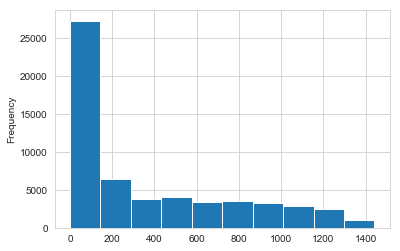

In [18]:
df_known['churn_days'] = df_known.days_until_next_comp.fillna(df_known.recency_comp)
df_known.churn_days.plot(kind='hist')

In [19]:
df_known['churned'] = [1 if x > churn_days else 0 for x in df_known.churn_days]

In [20]:
df_known.churned.value_counts()

1    35708
0    22668
Name: churned, dtype: int64

# Features

In [21]:
excl_feats = ['cluster_name', 'cluster_city', 'activity_state', 'aov', 'churn_factor', 'city',
              'completed_orders', 'customer_db_id', 'customer_id', 'days_until_next_order', 'email',
              'frequency', 'last_order', 'num_orders', 'order_db_id', 'order_id', 'order_num', 'recency',
              'segment', 'churn_days', 'churned' ,'product_combinations', 'customer_rescheduled',
              'internal_rescheduled', 'driver_db_id_PU', 'driver_db_id_DO', 'pickup_timeslot_from_datetime',
              'pickup_timeslot_to_datetime', 'pickup_zip', 'order_created_datetime' ,'order_created_month', 
              'order_created_year', 'product_type', 'order_x', 'order_y']
feats = [c for c in df_known.columns.tolist() if c not in excl_feats]
pred_name = 'churned'

In [55]:
feats = [
    # items
    'cluster', 'quantity', 'num_unique_products', 'laundry_distance',
    
    # behaviour
    'service_class_paid', 'voucher_revenue_ratio', 'revenue_brutto', 'last_revenue_brutto_diff',
    'completed_orders_ratio', 'days_since_last_comp', 'pickup_timeslot_from', 'software_type', 'voucher_channel',
    'voucher_used',
    
    # individual,
    'gender', 'corporate',
    
    # experience
    'fac_name', 'num_customer_reschedules', 'num_internal_reschedules', 
    'punctual_order', 'rating', 'reclean_order', 'refund_request']

In [56]:
# Encode
df_enc = df_known[feats + [pred_name]]

In [57]:
str_cols = df_enc.select_dtypes(include='object').columns
df_enc[str_cols] = df_enc[str_cols].apply(LabelEncoder().fit_transform)

In [58]:
df_enc.head().T

,245698,230011,206894,269430,258061
cluster,-999,-999,-999,-999,-999
quantity,-999,-999,-999,-999,-999
num_unique_products,-999,-999,-999,-999,-999
laundry_distance,-999,-999,-999,-999,-999
service_class_paid,False,False,False,False,False
voucher_revenue_ratio,0.672897,0.153846,0,0.25,0
revenue_brutto,31.0302,91.372,-999,55.1237,-999
last_revenue_brutto_diff,-999,-999,-999,-999,-999
completed_orders_ratio,0.5,1,1,1,1
days_since_last_comp,NaN,NaN,NaN,NaN,NaN


In [59]:
X = df_enc.drop(pred_name, axis=1).values
y = df_enc[pred_name].values
n_classes = df_enc[pred_name].nunique()
print(X.shape, y.shape)
print(n_classes)

(58376, 23) (58376,)
2


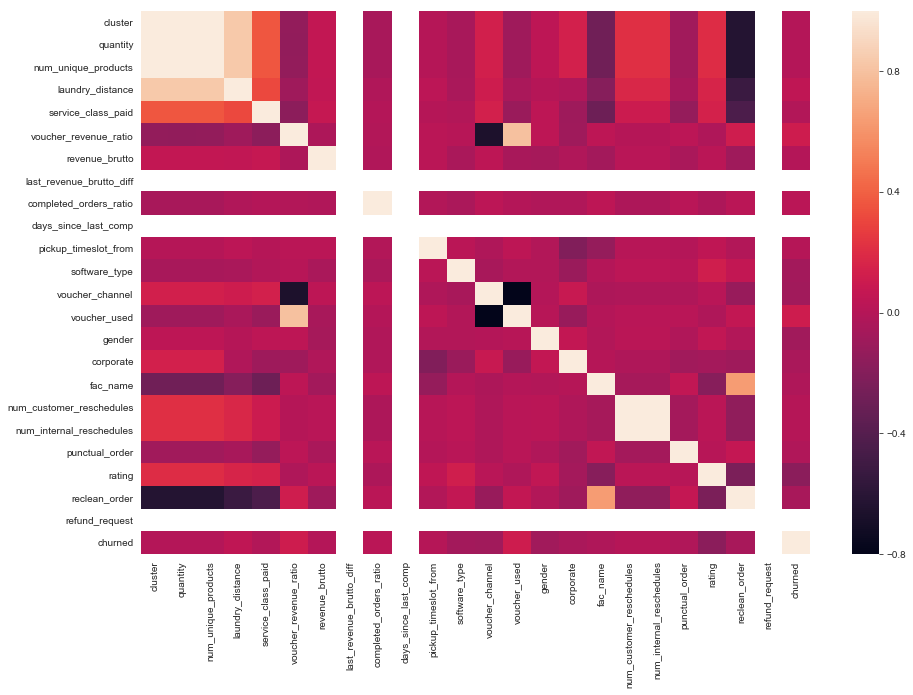

In [60]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_enc.corr(), xticklabels=df_enc.columns, yticklabels=df_enc.columns)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.3, max_depth=4, gamma=5, feature_names=feats)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose=True)

[0]	validation_0-auc:0.67464	validation_1-auc:0.675179
[1]	validation_0-auc:0.678259	validation_1-auc:0.677673
[2]	validation_0-auc:0.693622	validation_1-auc:0.69354
[3]	validation_0-auc:0.695611	validation_1-auc:0.694751
[4]	validation_0-auc:0.700411	validation_1-auc:0.698408
[5]	validation_0-auc:0.701768	validation_1-auc:0.699774
[6]	validation_0-auc:0.703957	validation_1-auc:0.700424
[7]	validation_0-auc:0.705498	validation_1-auc:0.701239
[8]	validation_0-auc:0.707988	validation_1-auc:0.70364
[9]	validation_0-auc:0.708592	validation_1-auc:0.703674
[10]	validation_0-auc:0.70961	validation_1-auc:0.70484
[11]	validation_0-auc:0.710624	validation_1-auc:0.705105
[12]	validation_0-auc:0.711703	validation_1-auc:0.705796
[13]	validation_0-auc:0.712271	validation_1-auc:0.706565
[14]	validation_0-auc:0.713869	validation_1-auc:0.708065
[15]	validation_0-auc:0.714726	validation_1-auc:0.708153
[16]	validation_0-auc:0.715069	validation_1-auc:0.70843
[17]	validation_0-auc:0.715898	validation_1-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1,
       feature_names=['cluster', 'quantity', 'num_unique_products', 'laundry_distance', 'service_class_paid', 'voucher_revenue_ratio', 'revenue_brutto', 'last_revenue_brutto_diff', 'completed_orders_ratio', 'days_since_last_comp', 'pickup_timeslot_from', 'software_type', 'voucher_channel', 'voucher_used', 'gender', 'corporate', 'fac_name', 'num_customer_reschedules', 'num_internal_reschedules', 'punctual_order', 'rating', 'reclean_order', 'refund_request'],
       gamma=5, learning_rate=0.3, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [63]:
print("Train Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_train, model.predict(X_train)) * 100))
print("Test Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, model.predict(X_test)) * 100))

Train Accuracy: 68.11%
Test Accuracy: 67.84%


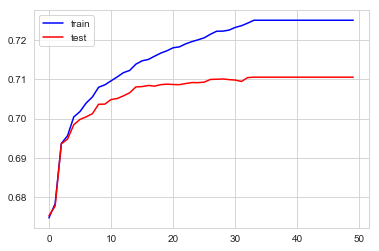

In [64]:
train_loss = model.evals_result()['validation_0']['auc']
test_loss = model.evals_result()['validation_1']['auc']
plt.figure()
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.legend(['train', 'test'])

In [65]:
fmap = dict(zip(["f"+str(i) for i in range(len(feats))],feats))

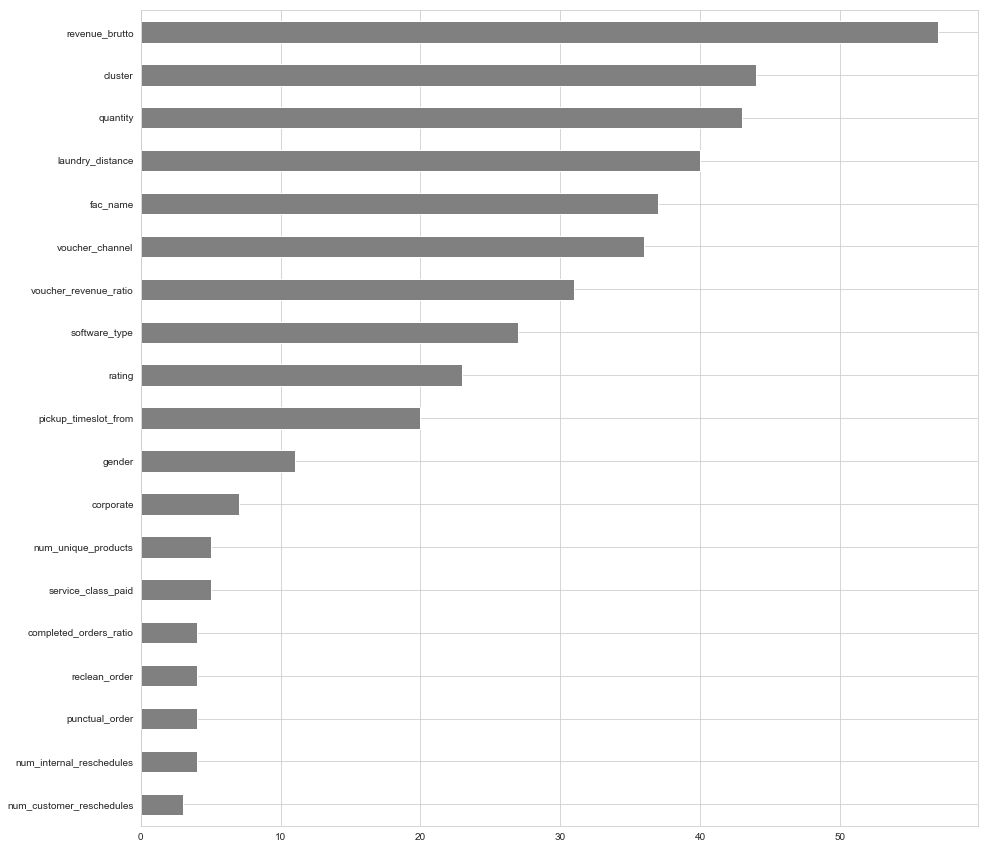

In [66]:
fig, ax = plt.subplots(figsize=(15,15))
df_imp = pd.Series(model.get_booster().get_fscore()).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')

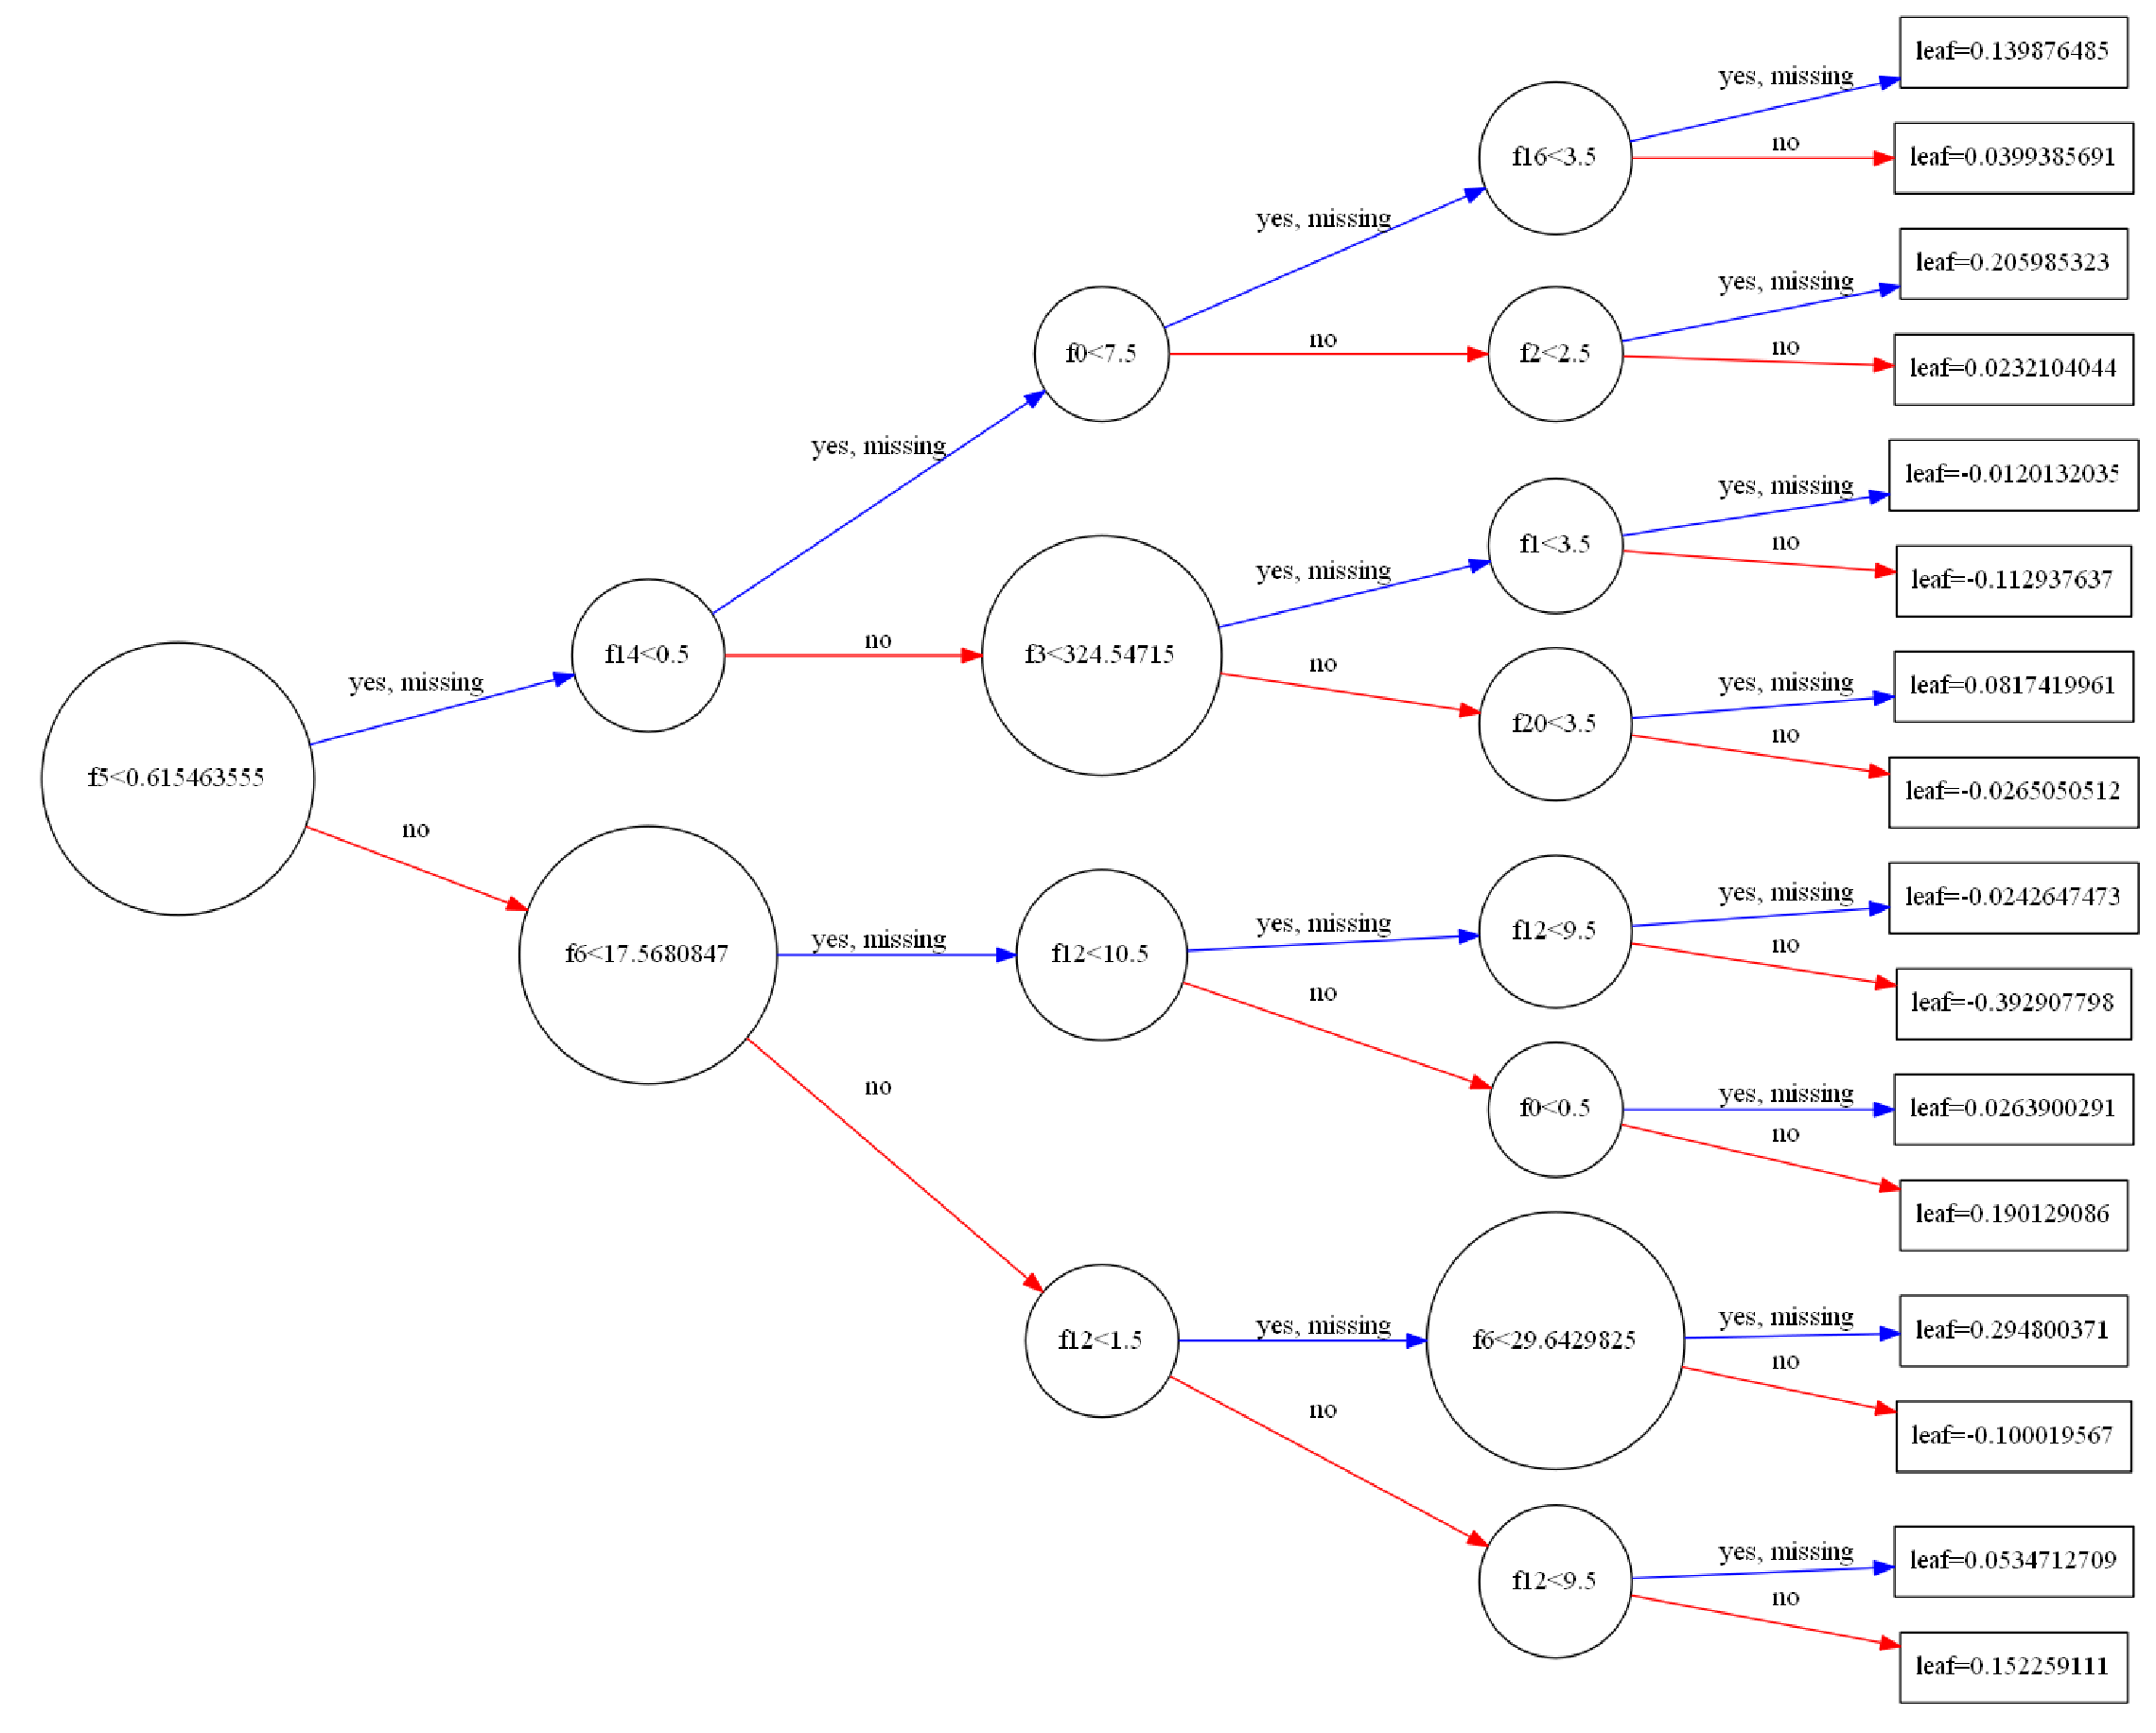

In [67]:
fig, ax = plt.subplots(figsize=(40,40))
xgb.plot_tree(model.get_booster(), ax=ax,rankdir='LR', num_trees=4)

In [54]:
fmap['f17']

'order_y'

In [36]:
# cvresult = xgb.cv(model.get_xgb_params(), dtrain=xgb.DMatrix(X_train, y_train), num_boost_round=model.get_params()['n_estimators'], nfold=5,
#          metrics='auc', early_stopping_rounds=10)
# cvresult

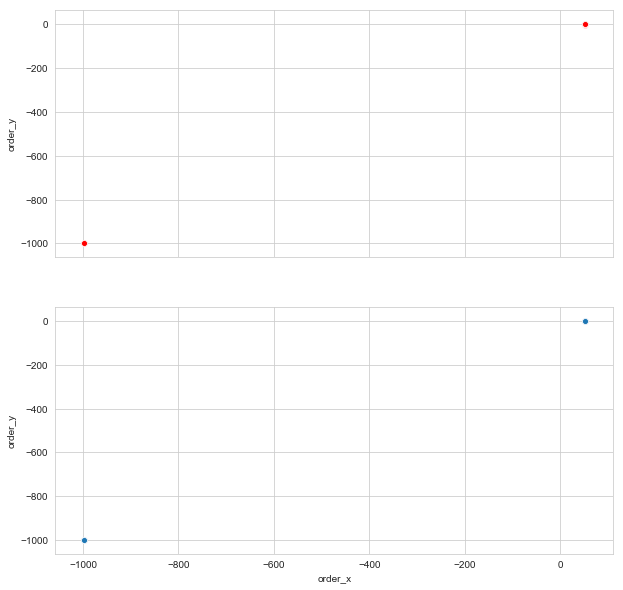

In [37]:
fig, axarr = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,10))
sns.scatterplot(x='order_x', y='order_y', data = df_known.loc[(df_known.city == 'London') & 
                                                              (df_known.order_x < 52) & (df_known.order_x != 0) &
                                                              (df_known.churned)], 
                alpha=1, color='red', ax=axarr[0])
sns.scatterplot(x='order_x', y='order_y', data = df_known.loc[(df_known.city == 'London') & (df_known.order_x != 0) &
                                                              (df_known.order_x < 52) & 
                                                              ~(df_known.churned)], 
                alpha=1, ax=axarr[1])
plt.show()

In [38]:
df_known[['order_x', 'order_y', 'churned']].corr()

,order_x,order_y,churned
order_x,1.000000,0.998772,0.013114
order_y,0.998772,1.000000,0.012255
churned,0.013114,0.012255,1.000000
